In [590]:
import pandas as pd

In [591]:
data = pd.read_csv('housing.csv')
data.shape

(20640, 10)

In [592]:
import matplotlib.pyplot as plt

In [593]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


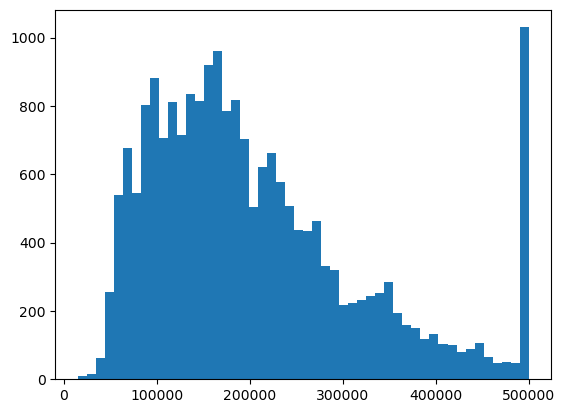

In [594]:
plt.hist(data['median_house_value'], bins=50);

In [595]:
cols = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']

In [596]:
data = data[cols]

# Question 1

In [597]:
data[cols].isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

Answer = 207

# Question 2

In [598]:
data['population'].median()

1166.0

Answer = 1166

# Split the data

In [599]:
import numpy as np

np.random.seed(seed=42)

We'll define a function so that we have reusable code 

In [600]:
def split_data(data, train_ratio = 0.6, test_ratio =0.2, val_ratio = 0.2):
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    
    train = int(train_ratio*len(idx))
    test = int(test_ratio*len(idx))
    val = int(val_ratio*len(idx))
    
    assert train_ratio + val_ratio + test_ratio == 1, "Ratio is wrong"
    
    y = data['median_house_value'].copy()
    X = data.drop(['median_house_value'], axis=1).copy()
    X_train = X.iloc[:train]
    X_val = X.iloc[train:train+val]
    X_test = X.iloc[-test:]

    y_train = np.log1p(y.iloc[:train])
    y_val = np.log1p(y.iloc[train:train+val])
    y_test = np.log1p(y.iloc[-test:])
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [601]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data)

In [602]:
X_train.shape

(12384, 8)

In [603]:
print(X_val.shape)
print(X_test.shape)

(4128, 8)
(4128, 8)


In [604]:
X_train.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462


# Question 3

In [605]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv @ (X.T) @ (y)
    
    return w[0], w[1:]

In [606]:
def RMSE(y_true, y_pred):
    return (np.sum((y_true - y_pred)**2) / y_true.shape[0]) ** 0.5

### option 1: fill with 0

In [607]:
X_train_zero = X_train.fillna(0)

In [608]:
X_train_zero.isnull().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

In [609]:
X_val_zero = X_val.fillna(0)

In [610]:
X_test_zero = X_test.fillna(0)

In [611]:
X_val_zero = X_val.fillna(0)

In [612]:
w0, w = train_linear_regression(X_train_zero, y_train)

In [613]:
y_pred = w0 + X_val_zero @ w

In [614]:
RMSE(y_pred, y_val)

0.3625894325000279

### option 2: fill with mean

In [615]:
mean_bedrooms = X_train['total_bedrooms'].mean()

In [616]:
X_train_mean = X_train.fillna(mean_bedrooms)

In [617]:
X_val_mean = X_val.fillna(mean_bedrooms)

In [618]:
w0, w = train_linear_regression(X_train_mean, y_train)

In [619]:
y_pred = w0 + X_val_mean.dot(w)

In [620]:
RMSE(y_pred, y_val)

0.36182431113908964

### Question 3 answer

we see a similar RMSE in the validation dataset.

# Question 4

In [621]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [622]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(X_train_zero, y_train, r)
    y_pred = w0 + X_val_zero.dot(w)
    print(r, RMSE(y_pred, y_val))

0 0.3625894325000279
1e-06 0.362589462105514
0.0001 0.36259239351873324
0.001 0.36261900374587513
0.01 0.3628813059467349
0.1 0.36517029035995696
1 0.37438535017323465
5 0.37972660330269625
10 0.38072631325010153


### Answer

A lot of r values give similar RMSE on the validation dataset

# Question 5

In [630]:
rmse = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed=seed)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(data, train_ratio=0.6, test_ratio=0.2, val_ratio = 0.2)
    X_val_zero = X_val.fillna(0)
    X_test_zero = X_test.fillna(0)
    X_train_zero = X_train.fillna(0)
    w0, w = train_linear_regression(X_train_zero, y_train)
    y_pred = w0 + X_val_zero.dot(w)
    rmse.append(RMSE(y_pred, y_val))

In [631]:
round(np.std(rmse), 3)

0.0

# Question 6

In [632]:
np.random.seed(seed=9)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data, train_ratio=0.8, test_ratio=0.2, val_ratio = 0)

In [633]:
X_train.shape

(16512, 8)

In [634]:
X_val.shape

(0, 8)

In [635]:
X_test.shape

(4128, 8)

In [636]:
X_test_zero = X_test.fillna(0)
X_train_zero = X_train.fillna(0)
w0, w = train_linear_regression_reg(X_train_zero, y_train, r=0.001)
y_pred = w0 + X_test_zero @ w
RMSE(y_pred, y_test)

0.3202775681840559